# Explore here

In [1]:
# Your code here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib

In [2]:
df = pd.read_csv('/workspaces/pille9-linear-regression/data/raw/medical_insurance_cost.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


In [3]:
df.shape

(1338, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
n_unicos = df.nunique()
n_unicos

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [6]:
# Revisar duplicados
df.duplicated().sum()

np.int64(1)

In [7]:
df = df.drop_duplicates().reset_index(drop = True)
df.shape

(1337, 7)

In [8]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1337.00,NaN,NaN,NaN,39.22,14.04,18.00,27.00,39.00,51.00,64.00
sex,1337,2,male,675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1337.00,NaN,NaN,NaN,30.66,6.10,15.96,26.29,30.40,34.70,53.13
children,1337.00,NaN,NaN,NaN,1.10,1.21,0.00,0.00,1.00,2.00,5.00
smoker,1337,2,no,1063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1337,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1337.00,NaN,NaN,NaN,13279.12,12110.36,1121.87,4746.34,9386.16,16657.72,63770.43


In [9]:
df["sex_n"] = pd.factorize(df["sex"], sort=True)[0]
df["smoker_n"] = pd.factorize(df["smoker"], sort=True)[0]
df["region_n"] = pd.factorize(df["region"], sort=True)[0]

df

,age,sex,bmi,children,smoker,region,charges,sex_n,smoker_n,region_n
0,19,female,27.90,0,yes,southwest,16884.92,0,1,3
1,18,male,33.77,1,no,southeast,1725.55,1,0,2
2,28,male,33.00,3,no,southeast,4449.46,1,0,2
3,33,male,22.70,0,no,northwest,21984.47,1,0,1
4,32,male,28.88,0,no,northwest,3866.86,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1332,50,male,30.97,3,no,northwest,10600.55,1,0,1
1333,18,female,31.92,0,no,northeast,2205.98,0,0,0
1334,18,female,36.85,0,no,southeast,1629.83,0,0,2
1335,21,female,25.80,0,no,southwest,2007.94,0,0,3


In [10]:
df_clean = df.drop(['sex', 'smoker', 'region'], axis=1)
df_clean

,age,bmi,children,charges,sex_n,smoker_n,region_n
0,19,27.90,0,16884.92,0,1,3
1,18,33.77,1,1725.55,1,0,2
2,28,33.00,3,4449.46,1,0,2
3,33,22.70,0,21984.47,1,0,1
4,32,28.88,0,3866.86,1,0,1
...,...,...,...,...,...,...,...
1332,50,30.97,3,10600.55,1,0,1
1333,18,31.92,0,2205.98,0,0,0
1334,18,36.85,0,1629.83,0,0,2
1335,21,25.80,0,2007.94,0,0,3


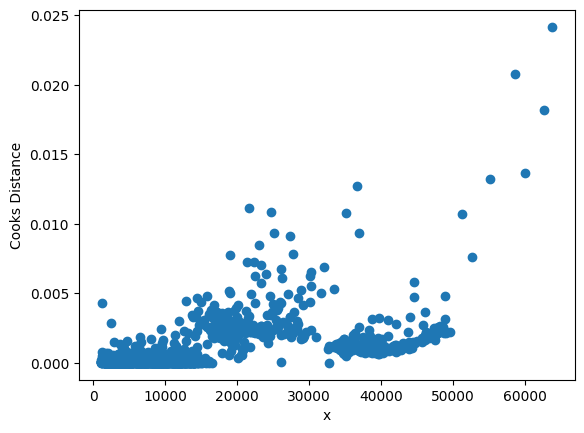

In [11]:
# Separar variable dependiente de independientes
X = df_clean.drop(['charges'], axis = 1)
y = df['charges']

# Ajustar modelo de regresión lineal
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()

# Distancia de cook
cooks_distance = model.get_influence().cooks_distance

plt.scatter(df_clean.charges, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [12]:
# Punto de corte para la distancia de cook
pto_corte = 4/len(df_clean)

# Anuncios por encima del pto de corte
len(np.where(cooks_distance[0]>pto_corte)[0])

# Eliminar observaciones que se consideran influentes
df_clean2 = df_clean.drop(np.where(cooks_distance[0] > pto_corte)[0])

In [13]:
# Separamos las variables independientes de la dependiente
X = df_clean2.drop(['charges'], axis=1)
y = df_clean2['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Usamos xgb para conocer la importancia de las características
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)
df_imp = pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100})
df_imp = df_imp.sort_values(by='Importance', ascending=False)
df_imp

,Feature,Importance
4,smoker_n,97.50
1,bmi,1.07
0,age,0.94
5,region_n,0.18
3,sex_n,0.16
2,children,0.14


In [15]:
# Seleccionamos las características que presentan más de un 0,9% de importancia
X_train = X_train[df_imp[df_imp.Importance>0.9]['Feature'].values]
X_test = X_test[df_imp[df_imp.Importance>0.9]['Feature'].values]

<Axes: >

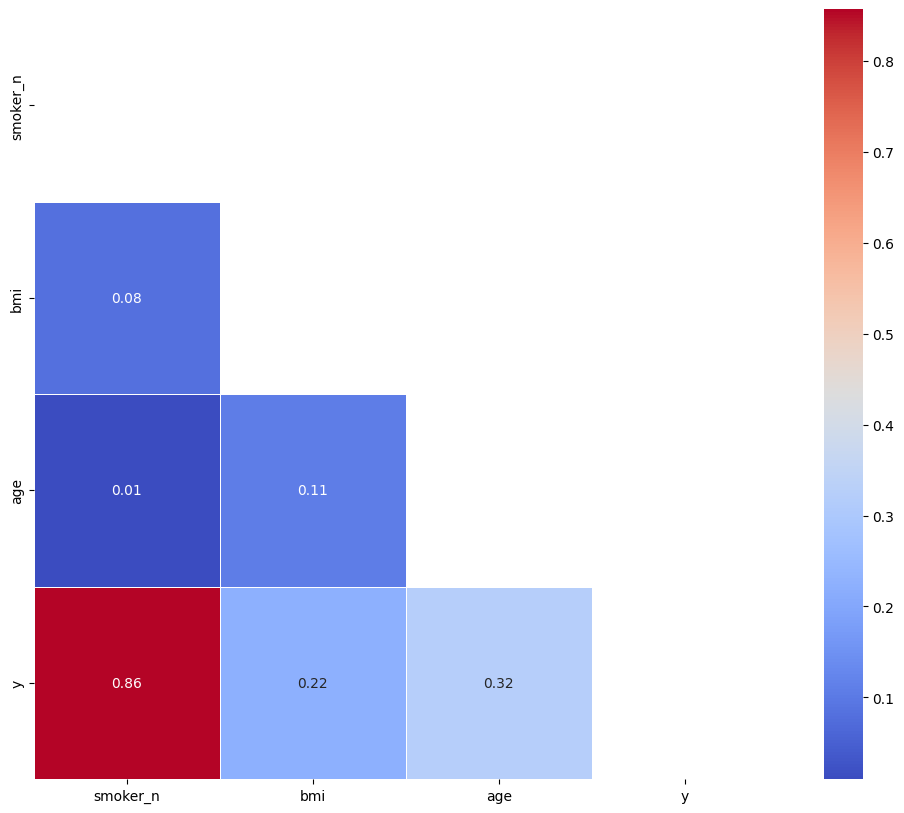

In [16]:
## VIF
X_train.corr()

vif = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns)
vif

X_corr = X_train.copy()
X_corr['y'] = y_train
corr = X_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

In [17]:
# Identificar las variables binarias
binary_cols = X_train[(X_train == 0)|(X_train == 1)].dropna(axis=1).columns
binary_cols

Index(['smoker_n'], dtype='object')

In [18]:
# seleciono las columnas que no son binarias
X_train_num = X_train.drop(binary_cols, axis=1)
X_test_num = X_test.drop(binary_cols, axis=1)

In [19]:
# Instancio la clase del escalador y lo ajusto con los datos de entrenamiento
scaler = MinMaxScaler().fit(X_train_num)

In [20]:
# Trasnformamos los datos numericos con el escalador ajustado
X_train_num_sc = scaler.transform(X_train_num)
X_test_num_sc = scaler.transform(X_test_num)

In [21]:
X_train_sc = pd.concat([pd.DataFrame(X_train_num_sc, columns = X_train_num.columns), X_train[binary_cols].reset_index(drop=True)], axis=1)
X_test_sc = pd.concat([pd.DataFrame(X_test_num_sc, columns = X_test_num.columns), X_test[binary_cols].reset_index(drop=True)], axis=1)

In [22]:
X_train_sc

,bmi,age,smoker_n
0,0.54,0.35,0
1,0.17,0.02,0
2,0.38,0.28,0
3,0.51,0.33,1
4,0.32,0.09,0
...,...,...,...
987,0.49,0.35,0
988,0.42,0.15,0
989,0.41,0.43,0
990,0.22,0.02,0


In [23]:
X_train_sc["charges"] = y_train.values
X_test_sc["charges"] = y_test.values
X_train_sc.to_csv("../data/processed/train_data.csv", index = False)
X_test_sc.to_csv("../data/processed/test_data.csv", index = False)

In [24]:
X_train = X_train_sc.drop(["charges"], axis = 1)
y_train = X_train_sc["charges"]
X_test = X_test_sc.drop(["charges"], axis = 1)
y_test = X_test_sc["charges"]

In [25]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [26]:
print(f"Intercepto (a): {model.intercept_}")
print(f"Coeficientes (b1, b2): {model.coef_}")

Intercepto (a): -1201.7828713502258
Coeficientes (b1, b2): [ 8266.12867252 11476.28237701 25344.93054127]


In [27]:
y_pred_test = model.predict(X_test)
y_pred_test

array([ 1.06057245e+04,  1.79904587e+03,  1.24913042e+04,  5.19289868e+03,
        3.99641072e+04,  8.37911194e+03,  4.36980880e+03,  1.09966236e+04,
        1.23514612e+04,  3.73077184e+04,  6.32329239e+03,  1.53567286e+04,
        6.77367701e+03,  5.94596628e+03,  2.00918133e+03,  3.23458305e+04,
        3.14788610e+03,  2.44136565e+03,  4.25093216e+03,  1.00397889e+04,
        1.00501306e+04,  1.26649576e+04,  9.65193889e+03,  1.10495456e+04,
        2.42280082e+03,  7.86878296e+03,  3.25660333e+03,  2.69657731e+03,
        1.12607874e+04,  1.43171348e+04, -3.01039889e+01,  3.40495466e+04,
        5.96351903e+03,  6.09071317e+03,  3.07125890e+04,  1.27230601e+04,
        4.60858058e+03,  6.42046074e+03,  3.26380774e+04,  7.92540804e+03,
        3.57896399e+03,  1.07004913e+04,  5.02710396e+03,  3.71991834e+04,
        1.17206903e+04,  2.37144414e+03,  6.44731036e+02,  4.04098540e+03,
        4.39586131e+03,  3.93956717e+03,  1.10738376e+04,  1.07073249e+04,
        6.39173651e+03,  

In [28]:
y_pred_train = model.predict(X_train)

In [29]:
def calculate_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular las métricas para entrenamiento
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)*100
    r2_train = r2_score(y_train, y_pred_train)

    # Calcular las métricas para test
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)*100
    r2_test = r2_score(y_test, y_pred_test)

    # Calcular las diferencias
    mae_diff = mae_test - mae_train
    mape_diff = mape_test - mape_train
    r2_diff = r2_test - r2_train

    # Crear el DataFrame
    metrics_df = pd.DataFrame({
        'MAE': [mae_train, mae_test, mae_diff],
        'MAPE': [mape_train, mape_test, mape_diff],
        'R2': [r2_train, r2_test, r2_diff]
    }, index=['Train', 'Test', 'Difference'])

    return metrics_df

In [30]:
calculate_metrics(y_train, y_test, y_pred_train, y_pred_test)

,MAE,MAPE,R2
Train,3016.94,33.31,0.85
Test,3037.13,30.17,0.81
Difference,20.19,-3.14,-0.03


Este tipo de modelos no se pueden optimizar, debido a la ausencia de hiperparámetros.